Examples
===================



SDP conversion
------------------



This example demonstrates the SDP conversion method. We first generate a random sparse SDP: 


In [1]:

from cvxopt import matrix, spmatrix, sparse, normal, solvers, blas
import chompack as cp
import random

# Function for generating random sparse matrix
def sp_rand(m,n,a):
    """
    Generates an m-by-n sparse 'd' matrix with round(a*m*n) nonzeros.
    """
    if m == 0 or n == 0: return spmatrix([], [], [], (m,n))
    nnz = min(max(0, int(round(a*m*n))), m*n)
    nz = matrix(random.sample(range(m*n), nnz), tc='i')
    return spmatrix(normal(nnz,1), nz%m, nz/m, (m,n))

# Generate random sparsity pattern and sparse SDP problem data
random.seed(1)
m, n = 50, 200
A = sp_rand(n,n,0.015) + spmatrix(1.0,range(n),range(n))
I = cp.tril(A)[:].I
N = len(I)/50 # each data matrix has 1/50 of total nonzeros in pattern
Ig = []; Jg = []
for j in range(m):
    Ig += sorted(random.sample(I,N))   
    Jg += N*[j]
G = spmatrix(normal(len(Ig),1),Ig,Jg,(n**2,m))
h = G*normal(m,1) + spmatrix(1.0,range(n),range(n))[:]
c = normal(m,1)
dims =  {'l':0, 'q':[], 's': [n]};



The problem can be solved using CVXOPT's cone LP solver:


In [2]:

prob = (c, G, matrix(h), dims)
sol = solvers.conelp(*prob)
Z1 = matrix(sol['z'], (n,n))


     pcost       dcost       gap    pres   dres   k/t
 0: -7.9591e+00 -2.9044e+02  3e+02  6e-16  2e+00  1e+00
 1: -1.1826e+01 -1.1054e+02  9e+01  4e-15  8e-01  4e-01
 2: -1.7892e+01 -9.9108e+01  8e+01  4e-15  7e-01  3e-01
 3: -2.3947e+01 -4.1603e+01  2e+01  2e-15  1e-01  8e-02
 4: -2.4646e+01 -3.7190e+01  1e+01  3e-15  1e-01  6e-02
 5: -2.6001e+01 -2.9393e+01  3e+00  3e-15  3e-02  2e-02
 6: -2.6000e+01 -2.9051e+01  3e+00  3e-15  3e-02  1e-02
 7: -2.6252e+01 -2.6796e+01  6e-01  2e-15  5e-03  3e-03
 8: -2.6272e+01 -2.6506e+01  2e-01  3e-15  2e-03  1e-03
 9: -2.6288e+01 -2.6345e+01  6e-02  2e-15  5e-04  3e-04
10: -2.6289e+01 -2.6326e+01  4e-02  3e-15  3e-04  2e-04
11: -2.6291e+01 -2.6296e+01  5e-03  3e-15  4e-05  3e-05
12: -2.6291e+01 -2.6292e+01  1e-03  3e-15  9e-06  6e-06
13: -2.6291e+01 -2.6291e+01  1e-04  2e-15  9e-07  6e-07
14: -2.6291e+01 -2.6291e+01  9e-06  2e-15  8e-08  5e-08
Optimal solution found.



An alternative is to convert the sparse SDP into a block-diagonal SDP using the conversion method and solve the converted problem using CVXOPT:


In [3]:

prob2, blocks_to_sparse, symbs = cp.convert_conelp(*prob)
sol2 = solvers.conelp(*prob2) 


     pcost       dcost       gap    pres   dres   k/t
 0: -7.9953e+00 -2.8985e+02  1e+03  9e-01  2e+00  1e+00
 1: -1.8054e+01 -8.9659e+01  1e+02  2e-01  6e-01  1e+00
 2: -2.2574e+01 -5.4864e+01  5e+01  1e-01  3e-01  7e-01
 3: -2.4720e+01 -3.4637e+01  1e+01  3e-02  8e-02  2e-01
 4: -2.5730e+01 -2.8667e+01  4e+00  9e-03  2e-02  4e-02
 5: -2.6107e+01 -2.6927e+01  1e+00  3e-03  7e-03  9e-03
 6: -2.6252e+01 -2.6400e+01  2e-01  5e-04  1e-03  1e-03
 7: -2.6279e+01 -2.6322e+01  5e-02  1e-04  4e-04  3e-04
 8: -2.6289e+01 -2.6295e+01  7e-03  2e-05  5e-05  3e-05
 9: -2.6291e+01 -2.6293e+01  2e-03  6e-06  2e-05  7e-06
10: -2.6291e+01 -2.6292e+01  5e-04  1e-06  3e-06  1e-06
11: -2.6291e+01 -2.6291e+01  1e-04  2e-07  6e-07  2e-07
12: -2.6291e+01 -2.6291e+01  2e-05  6e-08  2e-07  6e-08
13: -2.6291e+01 -2.6291e+01  5e-06  1e-08  3e-08  1e-08
Optimal solution found.



The solution to the original SDP can be found by mapping the block-diagonal solution to a sparse positive semidefinite completable matrix and computing a positive semidefinite completion:


In [4]:

# Map block-diagonal solution sol2['z'] to a sparse positive semidefinite completable matrix
blki,I,J,bn = blocks_to_sparse[0]
Z2 = spmatrix(sol2['z'][blki],I,J)

# Compute completion 
symb = cp.symbolic(Z2, p=cp.maxcardsearch)
Z2c = cp.psdcompletion(cp.cspmatrix(symb)+Z2, reordered=False)
Y2 = cp.mrcompletion(cp.cspmatrix(symb)+Z2, reordered=False)



The conversion can also be combined with clique-merging techniques in the symbolic factorization. This typically yields a block-diagonal SDP with fewer (but bigger) blocks than without clique-merging:


In [5]:

mf = cp.merge_size_fill(5,5)
prob3, blocks_to_sparse, symbs = cp.convert_conelp(*prob, coupling = 'full', merge_function = mf)
sol3 = solvers.conelp(*prob3) 


     pcost       dcost       gap    pres   dres   k/t
 0: -8.2758e+00 -2.9164e+02  6e+02  6e-01  2e+00  1e+00
 1: -1.8634e+01 -8.0009e+01  8e+01  1e-01  5e-01  9e-01
 2: -2.4495e+01 -4.5428e+01  3e+01  4e-02  2e-01  3e-01
 3: -2.5371e+01 -3.2361e+01  8e+00  1e-02  6e-02  5e-02
 4: -2.5903e+01 -2.8828e+01  3e+00  6e-03  2e-02  2e-02
 5: -2.6226e+01 -2.6782e+01  6e-01  1e-03  5e-03  3e-03
 6: -2.6275e+01 -2.6391e+01  1e-01  2e-04  1e-03  6e-04
 7: -2.6289e+01 -2.6308e+01  2e-02  4e-05  2e-04  1e-04
 8: -2.6291e+01 -2.6294e+01  3e-03  6e-06  2e-05  1e-05
 9: -2.6291e+01 -2.6292e+01  1e-03  2e-06  7e-06  4e-06
10: -2.6291e+01 -2.6291e+01  1e-04  2e-07  7e-07  4e-07
11: -2.6291e+01 -2.6291e+01  9e-06  2e-08  7e-08  4e-08
Optimal solution found.



Finally, we recover the solution to the original SDP:

In [6]:

# Map block-diagonal solution sol2['z'] to a sparse positive semidefinite completable matrix
blki,I,J,bn = blocks_to_sparse[0]
Z3 = spmatrix(sol3['z'][blki],I,J)

# Compute completion 
symb = cp.symbolic(Z3, p=cp.maxcardsearch)
Z3c = cp.psdcompletion(cp.cspmatrix(symb)+Z3, reordered=False)



Euclidean distance matrix completion
------------------------------------

    
Suppose that $A$ is a partial EDM of order $n$ where the squared distance $A_{ij} = \| p_i - p_j \|_2^2$ between two point $p_i$ and $p_j$ is known if $p_i$ and $p_j$ are sufficiently close. We will assume that $A_{ij}$ is known if and only if
 
 $$\| p_i - p_j \|_2^2 \leq \delta $$  
 
where $\delta$ is a positive constant. Let us generate a random partial EDM based on points in $\mathbb{R}^2$:


In [7]:

from cvxopt import uniform, spmatrix, matrix
import chompack as cp

d = 2              # dimension
n = 100            # number of points (order of A)
delta = 0.15**2    # distance threshold

P = uniform(d,n)   # generate n points with independent and uniformly distributed coordinates
Y = P.T*P          # Gram matrix

# Compute true distances:  At[i,j] = norm(P[:,i]-P[:,j])**2
#   At = diag(Y)*ones(1,n) + ones(n,1)*diag(Y).T - 2*Y
At = Y[::n+1]*matrix(1.0,(1,n)) + matrix(1.0,(n,1))*Y[::n+1].T - 2*Y

# Generate matrix with "observable distances"
#   A[i,j] = At[i,j] if At[i,j] <= delta
V,I,J = zip(*[(At[i,j],i,j) for j in range(n) for i in range(j,n) if At[i,j] <= delta])
A = spmatrix(V,I,J,(n,n))



The partial EDM $A$ may or may not be chordal. We can find a maximal chordal subgraph using the `maxchord` routine which returns a chordal matrix $A_{\mathrm{c}}$ and a perfect elimination order $p$. Note that if $A$ is chordal, then $A_{\mathrm{c}} = A$.


In [8]:

Ac,p = cp.maxchord(A)



The points $p_i$ and the known distances can be visualized using Matplotlib:


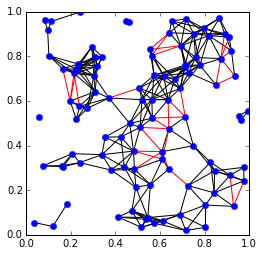

In [9]:

from pylab import plot,xlim,ylim,gca

# Extract entries in Ac and entries dropped from A
IJc = zip(Ac.I,Ac.J)
tmp = A - Ac
IJd = [(i,j) for i,j,v in zip(tmp.I,tmp.J,tmp.V) if v > 0]

# Plot edges
for i,j in IJc:    
    if i > j: plot([P[0,i],P[0,j]],[P[1,i],P[1,j]],'k-')
for i,j in IJd:
    if i > j: plot([P[0,i],P[0,j]],[P[1,i],P[1,j]],'r-')

# Plot points
plot(P[0,:].T,P[1,:].T, 'b.', ms=12)
xlim([0.,1.])
ylim([0.,1.])
gca().set_aspect('equal')



The edges represent known distances. The red edges are edges that were removed to produce the maximal chordal subgraph, and  the black edges are the edges of the chordal subgraph.



Next we compute a symbolic factorization of the chordal matrix $A_{\mathrm{c}}$ using the perfect elimination order $p$:


In [10]:

symb = cp.symbolic(Ac, p=p)
p = symb.p



Now `edmcompletion` can be used to compute an EDM completion of the chordal matrix $A_{\mathrm{c}}$:


In [11]:

X = cp.edmcompletion(cp.cspmatrix(symb)+Ac, reordered = False)



Symbolic factorization
----------------------------------



This example demonstrates the symbolic factorization. We start by generating a test problem and computing a symbolic factorization using the approximate minimum degree (AMD) ordering heuristic:


In [12]:

import chompack as cp
from cvxopt import spmatrix, amd

L = [[0,2,3,4,14],[1,2,3],[2,3,4,14],[3,4,14],[4,8,14,15],[5,8,15],[6,7,8,14],[7,8,14],[8,14,15],[9,10,12,13,16],[10,12,13,16],[11,12,13,15,16],[12,13,15,16],[13,15,16],[14,15,16],[15,16],[16]]
I = []
J = []
for k,l in enumerate(L):
    I.extend(l)
    J.extend(len(l)*[k])
    
A = spmatrix(1.0,I,J,(17,17))
symb = cp.symbolic(A, p=amd.order)



The sparsity graph can be visualized with the `sparsity_graph` routine if Matplotlib, NetworkX, and Graphviz are installed:


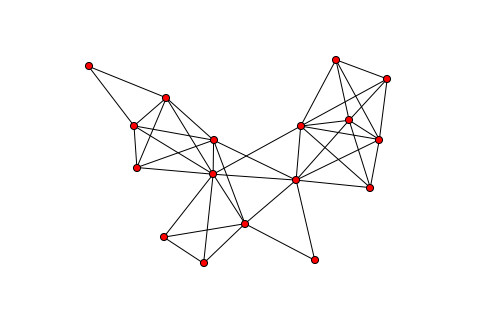

In [13]:

from chompack.pybase.plot import sparsity_graph
sparsity_graph(symb, node_size=50, with_labels=False)



The `sparsity_graph` routine passes all optional keyword arguments to NetworkX to make it easy to customize the visualization.

It is also possible to visualize the sparsity pattern using the `spy` routine which requires the packages Matplotlib, Numpy, and Scipy:


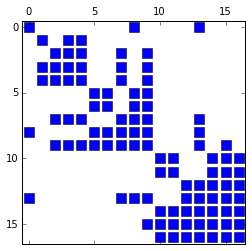

In [15]:

from chompack.pybase.plot import spy
fig = spy(symb, reordered=True)



The supernodes and the supernodal elimination tree can be extracted from the symbolic factorization as follows:


In [16]:

par = symb.parent()
snodes = symb.supernodes()

print "Id  Parent id  Supernode"
for k,sk in enumerate(snodes):
    print "%2i     %2i     "%(k,par[k]), sk
    

Id  Parent id  Supernode
 0      4      [0]
 1      2      [1]
 2      4      [2, 3, 4]
 3      4      [5, 6]
 4      5      [7, 8]
 5      7      [9]
 6      7      [10, 11]
 7      7      [12, 13, 14, 15, 16]



The supernodal elimination tree can be visualized with the `etree_graph` routine if Matplotlib, NetworkX, and Graphviz are installed:


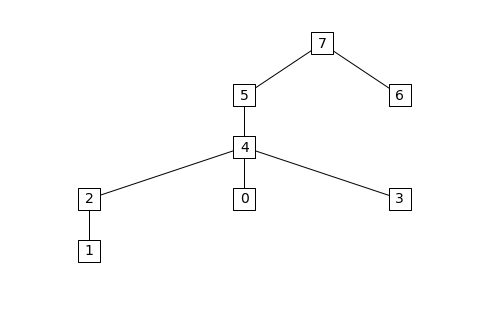

In [17]:

from chompack.pybase.plot import etree_graph
etree_graph(symb, with_labels=True, arrows=False, node_size=500, node_color='w', node_shape='s', font_size=14)
